# Generalize SSI to N neurons

author: laquitainesteeve@gmail.com

## Setup 

setup fisher_info_limits

```python
python -m ipykernel install --user --name fisher_info_limits --display-name "fisher_info_limits"
```

In [8]:
%load_ext autoreload
%autoreload 2

# import packages
import os
import numpy as np
from matplotlib import pyplot as plt;

# setup project path
main_dir = '/home/steeve/steeve/idv/code/fisher-info-limits'
os.chdir(main_dir)

# import custom package
import ssiProjectModule as ssiMod

# setup parameters
sample_size = 500
theta_step = 2
stim = np.arange(0, 360, theta_step) # stimulus direction space

# setup Bayesian parameters
N_TRIALS = 500

# setup paths
dat_dir_in = os.path.join(main_dir, 'data/decoding_analysis/')
data_dir = 'data/bayer_decoding_error/'+f'Bayes_Dec_Errs_{sample_size}reps_thetastep{theta_step}'+'.npz'
title = f'Stretch_BioQuads_multiplied_w_mean_g__theta_step={theta_step}_original_g_20240509_AREA.pkl'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [72]:
def create_tuning_curves(n_neurons: int, amplitude: float, width: float, baseline:float):
    """create tuning curves
    """
    # setup the preferred angle of each neuron
    preferred_angles = np.linspace(0, 360, n_neurons, endpoint=False) 

    # create tuning curves
    tuning_c = []
    for ix, pref_angle  in enumerate(preferred_angles):
        tuning_c.append(ssiMod.VON_MISES(th=stim, a=amplitude, th_0=pref_angle, s=width, baseline=baseline))
    return np.array(tuning_c)



def test_ssi_iterative(tuning_curves: np.array):
    """test new ssi vs original ssi computation 
    for 1 to 4 neurons"""

    # compute original ssi
    ssi = ssiMod.MC_SSI(tuning_curves)   

    # compute new ssi with 2 neurons
    ssi2 = ssiMod.mc_ssi_iterative(tuning_curves)

    # unit-test
    assert ssi.shape == (len(stim),), "ssi should be same length as stimulus count"
    assert np.allclose(ssi, ssi2,  atol=1e-08), "ssi should be the same"


def test_ssi_chunked(tuning_curves: np.array):
    """test new ssi vs original ssi computation 
    for 1 to 4 neurons"""

    # compute original ssi
    ssi = ssiMod.MC_SSI(tuning_curves)   

    # compute new ssi with 2 neurons
    ssi2 = ssiMod.mc_ssi_chunked(tuning_curves)

    # unit-test
    assert ssi.shape == (len(stim),), "ssi should be same length as stimulus count"
    assert np.allclose(ssi, ssi2,  atol=1e-08), "ssi should be the same"


def test_ssi_adaptive_monte_carlo(tuning_curves: np.array, atol=1e-08):
    """test new ssi vs original ssi computation 
    for 1 to 4 neurons"""

    # compute original ssi
    ssi = ssiMod.MC_SSI(tuning_curves)   

    # compute new ssi with 2 neurons
    ssi2 = ssiMod.ssi_adaptive_monte_carlo(tuning_curves)

    # unit-test
    assert ssi.shape == (len(stim),), "ssi should be same length as stimulus count"
    assert np.allclose(ssi, ssi2,  atol=atol), "ssi should be the same"

## Unit-tests

### Compute ssi iteratively

In [3]:
%%time 

# n_neurons for a tiling with 20 neurons (Kriegeskorte, Nature, Rev, Neuro)
# amplitude for 19 spikes/secs (Albright, 1984)  (from Gaussian fit)
# width for 32 deg std (~75 deg FWHM), validated across species (from Gaussian fit)
tc_prms = {"amplitude": 780, "width": 0.29, "baseline": 0}

# unit-test 2 neurons
tuning_curves = create_tuning_curves(n_neurons=2, **tc_prms)
test_ssi_iterative(tuning_curves) 

# unit-test 3 neurons
tuning_curves = create_tuning_curves(n_neurons=3, **tc_prms)
test_ssi_iterative(tuning_curves) # unit-test

# unit-test 4 neurons
tuning_curves = create_tuning_curves(n_neurons=4, **tc_prms)
test_ssi_iterative(tuning_curves) # unit-test

CPU times: user 11.8 s, sys: 4.76 s, total: 16.5 s
Wall time: 16.5 s


### Compute ssi in batch-mode

- By breaking down likelihood into batches of possible response spike counts

In [51]:
%%time 

# n_neurons for a tiling with 20 neurons (Kriegeskorte, Nature, Rev, Neuro)
# amplitude for 19 spikes/secs (Albright, 1984)  (from Gaussian fit)
# width for 32 deg std (~75 deg FWHM), validated across species (from Gaussian fit)
tc_prms = {"amplitude": 780, "width": 0.29, "baseline": 0}

# unit-test 2 neurons
tuning_curves = create_tuning_curves(n_neurons=2, **tc_prms)
test_ssi_chunked(tuning_curves) 

# unit-test 3 neurons
tuning_curves = create_tuning_curves(n_neurons=3, **tc_prms)
test_ssi_chunked(tuning_curves) # unit-test

# unit-test 4 neurons
tuning_curves = create_tuning_curves(n_neurons=4, **tc_prms)
test_ssi_chunked(tuning_curves) # unit-test

CPU times: user 12.2 s, sys: 3.3 s, total: 15.5 s
Wall time: 15.5 s


In [ ]:
%%time 
# 7 m for 5 neurons
tuning_curves = create_tuning_curves(n_neurons=20, **tc_prms)
ssi = ssiMod.mc_ssi_chunked(tuning_curves)

### Compute ssi with adaptive monte carlo

In [73]:
%%time 

# n_neurons for a tiling with 20 neurons (Kriegeskorte, Nature, Rev, Neuro)
# amplitude for 19 spikes/secs (Albright, 1984)  (from Gaussian fit)
# width for 32 deg std (~75 deg FWHM), validated across species (from Gaussian fit)
tc_prms = {"amplitude": 780, "width": 0.29, "baseline": 0}

# unit-test 2 neurons
tuning_curves = create_tuning_curves(n_neurons=2, **tc_prms)
test_ssi_adaptive_monte_carlo(tuning_curves, atol=1e-3) 

# unit-test 3 neurons
tuning_curves = create_tuning_curves(n_neurons=3, **tc_prms)
test_ssi_adaptive_monte_carlo(tuning_curves, atol=1e-3) # unit-test

# unit-test 4 neurons
tuning_curves = create_tuning_curves(n_neurons=4, **tc_prms)
test_ssi_adaptive_monte_carlo(tuning_curves, atol=1e-3) # unit-test

AssertionError: ssi should be the same

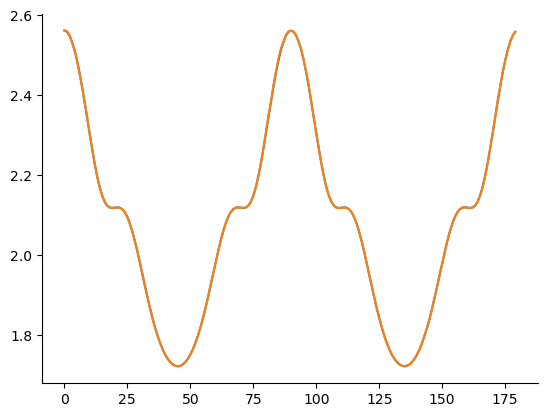

In [74]:
# compute new ssi with adaptive monte carlo for 2 neurons
tuning_curves = create_tuning_curves(n_neurons=2, **tc_prms)
ssi = ssiMod.MC_SSI(tuning_curves)
ssi2 = ssiMod.ssi_adaptive_monte_carlo(tuning_curves, num_samples=1000, max_num_samples=10**10, error=0.1)
plt.plot(ssi)
plt.plot(ssi2)